# TITANIC KAGGLE COMPETITION

## DATA IMPORT

In [11]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display 
import seaborn as sns; sns.set()
import visuals as vs
from sklearn.preprocessing import MinMaxScaler, Imputer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances_argmin, silhouette_score, accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from keras import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint  
from sklearn.model_selection import StratifiedKFold
from keras import regularizers
import matplotlib.pyplot as plt
%matplotlib inline 

In [12]:
# Load the dataset
try:
    dataset = pd.read_csv("data/train.csv")
    print("Passengers dataset has {} samples with {} features each.".format(*dataset.shape))
except Exception as e:
    print("Dataset could not be loaded. Is the dataset missing? ", str(e))

Passengers dataset has 891 samples with 12 features each.


In [13]:
dataset.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

In [14]:
display(dataset.describe())

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

## DATA EXPLORATION

For each feature we are going to identify:
- Number of unique of values
- Empty values and best way to fill in NaN
- Group by mean
- It relation to survived label
- How can we transform it to best fit our model

### Pclass

In [15]:
empty_values = dataset['Pclass'].isna().sum()
print('Empty values: ', empty_values)
print('Empty percentage: ', empty_values/len(dataset['Pclass']))
print('Unique values: ',len(dataset['Pclass'].unique()))

Empty values:  0
Empty percentage:  0.0
Unique values:  3


In [16]:
print(dataset.groupby('Pclass').mean())

        PassengerId  Survived        Age     SibSp     Parch       Fare
Pclass                                                                 
1        461.597222  0.629630  38.233441  0.416667  0.356481  84.154687
2        445.956522  0.472826  29.877630  0.402174  0.380435  20.662183
3        439.154786  0.242363  25.140620  0.615071  0.393075  13.675550


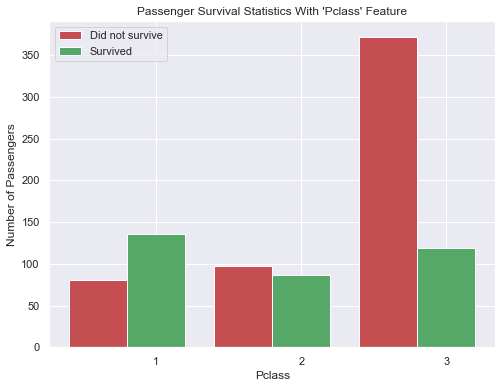

In [17]:
vs.survival_stats(dataset.drop('Survived', axis=1), dataset['Survived'], 'Pclass')

`Pclass` is a category column so probably best way to fill NaN values is to use more frequent value. Also we are to one hot encode values.

In [18]:
def processPclass (dataset) :
    dataset['Pclass'] = dataset['Pclass'].fillna(dataset['Pclass'].value_counts().index[0])
    dataset = pd.get_dummies(dataset, columns=['Pclass'])
    return dataset

In [19]:
dataset = processPclass(dataset)
dataset.head(10)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   
5            6         0                                   Moran, Mr. James   
6            7         0                            McCarthy, Mr. Timothy J   
7            8         0                     Palsson, Master. Gosta Leonard   
8            9         1  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9           10         1                Nasser, Mrs. Nicholas (Adele Achem)   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  \
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S   
1  female  38.0      1      0          PC 17599  71.2833   C85        C   
2  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S   
3  female  35.0      1      0            113803  53.1000  C123        S   
4    male  35.0      0      0            373450   8.0500   NaN        S   
5    male   NaN      0      0            330877   8.4583   NaN        Q   
6    male  54.0      0      0             17463  51.8625   E46        S   
7    male   2.0      3      1            349909  21.0750   NaN        S   
8  female  27.0      0      2            347742  11.1333   NaN        S   
9  female  14.0      1      0            237736  30.0708   NaN        C   

   Pclass_1  Pclass_2  Pclass_3  
0         0         0         1  
1         1         0         0  
2         0         0         1  
3         1         0         0  
4         0         0         1  
5         0         0         1  
6         1         0         0  
7         0         0         1  
8         0         0         1  
9         0         1         0

### Age

In [20]:
empty_values = dataset['Age'].isna().sum()
print('Empty values: ', empty_values)
print('Empty percentage: ', empty_values/len(dataset['Age']))
print('Unique values: ',len(dataset['Age'].unique()))

Empty values:  177
Empty percentage:  0.19865319865319866
Unique values:  89


In [21]:
print(dataset.groupby('Age').mean())

       PassengerId  Survived  SibSp  Parch      Fare  Pclass_1  Pclass_2  \
Age                                                                        
0.42         804.0       1.0    0.0    1.0    8.5167       0.0       0.0   
0.67         756.0       1.0    1.0    1.0   14.5000       0.0       1.0   
0.75         557.5       1.0    2.0    1.0   19.2583       0.0       0.0   
0.83         455.5       1.0    0.5    1.5   23.8750       0.0       1.0   
0.92         306.0       1.0    1.0    2.0  151.5500       1.0       0.0   
...            ...       ...    ...    ...       ...       ...       ...   
70.00        709.5       0.0    0.5    0.5   40.7500       0.5       0.5   
70.50        117.0       0.0    0.0    0.0    7.7500       0.0       0.0   
71.00        295.5       0.0    0.0    0.0   42.0792       1.0       0.0   
74.00        852.0       0.0    0.0    0.0    7.7750       0.0       0.0   
80.00        631.0       1.0    0.0    0.0   30.0000       1.0       0.0   

       Pcla

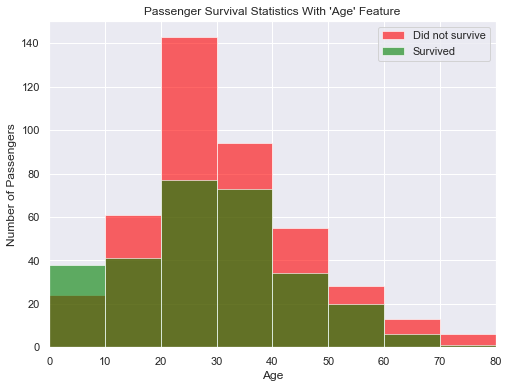

In [22]:
vs.survival_stats(dataset.drop('Survived', axis=1), dataset['Survived'], 'Age')

Fill NaN strategy should not use mean as record are not equally distributed.

In [23]:
def processAge(dataset) : 
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].quantile(.5))
    return dataset

In [24]:
dataset = processAge(dataset)
dataset.head(5)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  \
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S   
1  female  38.0      1      0          PC 17599  71.2833   C85        C   
2  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S   
3  female  35.0      1      0            113803  53.1000  C123        S   
4    male  35.0      0      0            373450   8.0500   NaN        S   

   Pclass_1  Pclass_2  Pclass_3  
0         0         0         1  
1         1         0         0  
2         0         0         1  
3         1         0         0  
4         0         0         1

Numerical value columns are going to be log transformed later so lets store column name.

In [25]:
num_columns = ['Age']

### Sex

In [26]:
empty_values = dataset['Sex'].isna().sum()
print('Empty values: ', empty_values)
print('Empty percentage: ', empty_values/len(dataset['Sex']))
print('Unique values: ',len(dataset['Sex'].unique()))

Empty values:  0
Empty percentage:  0.0
Unique values:  2


In [27]:
print(dataset.groupby('Sex').mean())

        PassengerId  Survived        Age     SibSp     Parch       Fare  \
Sex                                                                       
female   431.028662  0.742038  27.929936  0.694268  0.649682  44.479818   
male     454.147314  0.188908  30.140676  0.429809  0.235702  25.523893   

        Pclass_1  Pclass_2  Pclass_3  
Sex                                   
female  0.299363  0.242038  0.458599  
male    0.211438  0.187175  0.601386  


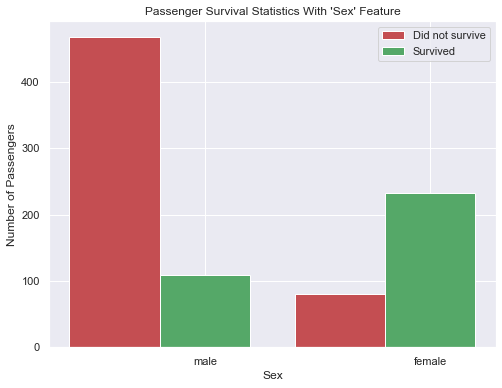

In [28]:
vs.survival_stats(dataset.drop('Survived', axis=1), dataset['Survived'], 'Sex')

In [29]:
def processSex(dataset) :
    dataset['Sex'] = dataset['Sex'].fillna(dataset['Sex'].value_counts().index[0])
    dataset = pd.get_dummies(dataset, columns=['Sex'])    
    return dataset

In [30]:
dataset = processSex(dataset)
dataset.head(5)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare Cabin Embarked  Pclass_1  \
0  22.0      1      0         A/5 21171   7.2500   NaN        S         0   
1  38.0      1      0          PC 17599  71.2833   C85        C         1   
2  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S         0   
3  35.0      1      0            113803  53.1000  C123        S         1   
4  35.0      0      0            373450   8.0500   NaN        S         0   

   Pclass_2  Pclass_3  Sex_female  Sex_male  
0         0         1           0         1  
1         0         0           1         0  
2         0         1           1         0  
3         0         0           1         0  
4         0         1           0         1

### Embarked
Same strategy as Sex

In [31]:
def processEmbarked(dataset) :
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].value_counts().index[0])
    dataset = pd.get_dummies(dataset, columns=['Embarked'])    
    return dataset

In [32]:
dataset = processEmbarked(dataset)
dataset.head(5)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare Cabin  Pclass_1  Pclass_2  \
0  22.0      1      0         A/5 21171   7.2500   NaN         0         0   
1  38.0      1      0          PC 17599  71.2833   C85         1         0   
2  26.0      0      0  STON/O2. 3101282   7.9250   NaN         0         0   
3  35.0      1      0            113803  53.1000  C123         1         0   
4  35.0      0      0            373450   8.0500   NaN         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0         1           0           0           1  
1         0           1         0           1           0           0  
2         1           1         0           0           0           1  
3         0           1         0           0           0           1  
4         1           0         1           0           0           1

### Fare
Fill in Nan with quantile 50

In [33]:
def processFare(dataset) :
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].quantile(.5))
    return dataset

In [34]:
dataset = processFare(dataset)

In [35]:
dataset.head(5)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare Cabin  Pclass_1  Pclass_2  \
0  22.0      1      0         A/5 21171   7.2500   NaN         0         0   
1  38.0      1      0          PC 17599  71.2833   C85         1         0   
2  26.0      0      0  STON/O2. 3101282   7.9250   NaN         0         0   
3  35.0      1      0            113803  53.1000  C123         1         0   
4  35.0      0      0            373450   8.0500   NaN         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0         1           0           0           1  
1         0           1         0           1           0           0  
2         1           1         0           0           0           1  
3         0           1         0           0           0           1  
4         1           0         1           0           0           1

In [36]:
num_columns.append('Fare')

### Sibsp and Parch

In [37]:
def processSibsp(dataset) :
    dataset['SibSp'] = dataset['SibSp'].fillna(dataset['SibSp'].value_counts().index[0])
    dataset['Parch'] = dataset['Parch'].fillna(dataset['Parch'].value_counts().index[0])
    return dataset

In [38]:
dataset = processSibsp(dataset)
dataset.head(5)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp  Parch            Ticket     Fare Cabin  Pclass_1  Pclass_2  \
0  22.0      1      0         A/5 21171   7.2500   NaN         0         0   
1  38.0      1      0          PC 17599  71.2833   C85         1         0   
2  26.0      0      0  STON/O2. 3101282   7.9250   NaN         0         0   
3  35.0      1      0            113803  53.1000  C123         1         0   
4  35.0      0      0            373450   8.0500   NaN         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0         1           0           0           1  
1         0           1         0           1           0           0  
2         1           1         0           0           0           1  
3         0           1         0           0           0           1  
4         1           0         1           0           0           1

In [39]:
num_columns.append('SibSp')
num_columns.append('Parch')

### Cabin

In [40]:
empty_values = dataset['Cabin'].isna().sum()
print('Empty values: ', empty_values)
print('Empty percentage: ', empty_values/len(dataset['Cabin']))
print('Unique values: ',len(dataset['Cabin'].unique()))

Empty values:  687
Empty percentage:  0.7710437710437711
Unique values:  148


There are a lot of empty values. Let's check if empty values are relvant for survival

In [41]:
alive = len(dataset.loc[(dataset['Survived'] == 1) & (dataset['Cabin'].isnull())])
dead = len(dataset.loc[(dataset['Survived'] == 0) & (dataset['Cabin'].isnull())])
#Sin cabina
print('Without cabin alive/dead', alive/dead)
alive = len(dataset.loc[(dataset['Survived'] == 1) & (dataset['Cabin'].notnull())])
dead = len(dataset.loc[(dataset['Survived'] == 0) & (dataset['Cabin'].notnull())])
print('With cabin alive/dead', alive/dead)

Without cabin alive/dead 0.4282744282744283
With cabin alive/dead 2.0


In [42]:
def processCabin(dataset) :
    dataset.loc[dataset['Cabin'].notnull(), 'Cabin'] = 1
    dataset['Cabin'].fillna(0, inplace=True)
    dataset = pd.get_dummies(dataset, columns=['Cabin'])  
    return dataset

In [43]:
dataset = processCabin(dataset)
dataset.head(5)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   
5            6         0                                   Moran, Mr. James   
6            7         0                            McCarthy, Mr. Timothy J   
7            8         0                     Palsson, Master. Gosta Leonard   
8            9         1  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9           10         1                Nasser, Mrs. Nicholas (Adele Achem)   

    Age  SibSp  Parch            Ticket     Fare  Pclass_1  Pclass_2  \
0  22.0      1      0         A/5 21171   7.2500         0         0   
1  38.0      1      0          PC 17599  71.2833         1         0   
2  26.0      0      0  STON/O2. 3101282   7.9250         0         0   
3  35.0      1      0            113803  53.1000         1         0   
4  35.0      0      0            373450   8.0500         0         0   
5  28.0      0      0            330877   8.4583         0         0   
6  54.0      0      0             17463  51.8625         1         0   
7   2.0      3      1            349909  21.0750         0         0   
8  27.0      0      2            347742  11.1333         0         0   
9  14.0      1      0            237736  30.0708         0         1   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
0         1           0         1           0           0           1   
1         0           1         0           1           0           0   
2         1           1         0           0           0           1   
3         0           1         0           0           0           1   
4         1           0         1           0           0           1   
5         1           0         1           0           1           0   
6         0           0         1           0           0           1   
7         1           0         1           0           0           1   
8         1           1         0           0           0           1   
9         0           1         0           1           0           0   

   Cabin_0  Cabin_1  
0        1        0  
1        0        1  
2        1        0  
3        0        1  
4        1        0  
5        1        0  
6        0        1  
7        1        0  
8        1        0  
9        1        0

### Name and ticket

In [44]:
empty_values = dataset['Name'].isna().sum()
print('Empty values: ', empty_values)
print('Empty percentage: ', empty_values/len(dataset['Name']))
print('Unique values: ',len(dataset['Name'].unique()))

Empty values:  0
Empty percentage:  0.0
Unique values:  891


In [45]:
empty_values = dataset['Ticket'].isna().sum()
print('Empty values: ', empty_values)
print('Empty percentage: ', empty_values/len(dataset['Ticket']))
print('Unique values: ',len(dataset['Ticket'].unique()))

Empty values:  0
Empty percentage:  0.0
Unique values:  681


In [46]:
def processNameAndTicket(dataset) :
    dataset.drop('Ticket', axis=1, inplace=True)
    dataset.drop('Name', axis=1, inplace=True)
    return dataset

In [47]:
dataset = processNameAndTicket(dataset)
dataset.head(10)

PassengerId  Survived   Age  SibSp  Parch     Fare  Pclass_1  Pclass_2  \
0            1         0  22.0      1      0   7.2500         0         0   
1            2         1  38.0      1      0  71.2833         1         0   
2            3         1  26.0      0      0   7.9250         0         0   
3            4         1  35.0      1      0  53.1000         1         0   
4            5         0  35.0      0      0   8.0500         0         0   
5            6         0  28.0      0      0   8.4583         0         0   
6            7         0  54.0      0      0  51.8625         1         0   
7            8         0   2.0      3      1  21.0750         0         0   
8            9         1  27.0      0      2  11.1333         0         0   
9           10         1  14.0      1      0  30.0708         0         1   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
0         1           0         1           0           0           1   
1         0           1         0           1           0           0   
2         1           1         0           0           0           1   
3         0           1         0           0           0           1   
4         1           0         1           0           0           1   
5         1           0         1           0           1           0   
6         0           0         1           0           0           1   
7         1           0         1           0           0           1   
8         1           1         0           0           0           1   
9         0           1         0           1           0           0   

   Cabin_0  Cabin_1  
0        1        0  
1        0        1  
2        1        0  
3        0        1  
4        1        0  
5        1        0  
6        0        1  
7        1        0  
8        1        0  
9        1        0

In [48]:
dataset.to_pickle('data/processed_dataset.pkl')

## DATA TRANSFORMATION & OUTLIERS REMOVAL

In [91]:
dataset = pd.read_pickle('data/processed_dataset.pkl')

In [92]:
# Split the data into features and target label
survival_raw = dataset['Survived']
features_raw = dataset.drop('Survived', axis = 1)
print(len(survival_raw))

891


In [93]:
def logTransform(features_raw,num_columns) :
    # Log transform numerical value colums
    features_log_transformed = pd.DataFrame(data = features_raw)
    features_log_transformed[num_columns] = features_raw[num_columns].apply(lambda x: np.log(x + 1))
    scaler = MinMaxScaler() # default=(0, 1)
    features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
    features_log_minmax_transform[num_columns] = scaler.fit_transform(features_log_transformed[num_columns])
    return features_log_minmax_transform

In [94]:
features_log_minmax_transform = logTransform(features_raw, num_columns)
display(features_log_minmax_transform.head(n = 5))

PassengerId       Age     SibSp  Parch      Fare  Pclass_1  Pclass_2  \
0            1  0.688670  0.315465    0.0  0.338125         0         0   
1            2  0.819257  0.315465    0.0  0.685892         1         0   
2            3  0.728321  0.000000    0.0  0.350727         0         0   
3            4  0.799463  0.315465    0.0  0.639463         1         0   
4            5  0.799463  0.000000    0.0  0.352955         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
0         1           0         1           0           0           1   
1         0           1         0           1           0           0   
2         1           1         0           0           0           1   
3         0           1         0           0           0           1   
4         1           0         1           0           0           1   

   Cabin_0  Cabin_1  
0        1        0  
1        0        1  
2        1        0  
3        0        1  
4        1        0

In [97]:
dataset = features_log_minmax_transform
all_outliers = []
for feature in dataset.columns :
    
    Q1 = np.percentile(dataset[feature], 20)
    Q3 = np.percentile(dataset[feature], 80)
    step = (Q3 - Q1)*1.5
    
    feature_outliers = dataset[~((dataset[feature] >= Q1 - step) & (dataset[feature] <= Q3 + step))]
    if len(feature_outliers) == 0 :
        continue
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(feature_outliers)
    
    all_outliers.extend(feature_outliers.index.values)
    
import collections
outliers =  [item for item, count in collections.Counter(all_outliers).items() if count > 1]
print('Outliers detected in more than one feature:',len(outliers))
print('Original records:',len(dataset))

Data points considered outliers for the feature 'Age':


PassengerId       Age     SibSp     Parch      Fare  Pclass_1  Pclass_2  \
7              8  0.184964  0.630930  0.356207  0.495832         0         0   
10            11  0.311287  0.315465  0.356207  0.460439         0         0   
50            51  0.427516  0.732487  0.356207  0.593810         0         0   
58            59  0.356374  0.315465  0.564575  0.538164         0         1   
63            64  0.311287  0.630930  0.564575  0.538998         0         0   
78            79  0.062728  0.000000  0.564575  0.544984         0         1   
119          120  0.184964  0.732487  0.564575  0.556696         0         0   
164          165  0.084695  0.732487  0.356207  0.593810         0         0   
172          173  0.084695  0.315465  0.356207  0.399934         0         0   
183          184  0.084695  0.500000  0.356207  0.591080         0         1   
184          185  0.311287  0.000000  0.564575  0.502583         0         0   
193          194  0.256106  0.315465  0.356207  0.528101         0         1   
205          206  0.184964  0.000000  0.356207  0.390821         0         0   
233          234  0.356374  0.732487  0.564575  0.557253         0         0   
261          262  0.256106  0.732487  0.564575  0.557253         0         0   
297          298  0.184964  0.315465  0.564575  0.805569         1         0   
305          306  0.074600  0.315465  0.564575  0.805569         1         0   
340          341  0.184964  0.315465  0.356207  0.528101         0         1   
348          349  0.256106  0.315465  0.356207  0.453029         0         0   
374          375  0.256106  0.630930  0.356207  0.495832         0         0   
407          408  0.256106  0.315465  0.356207  0.477999         0         1   
445          446  0.311287  0.000000  0.564575  0.707770         1         0   
479          480  0.184964  0.000000  0.356207  0.414494         0         0   
530          531  0.184964  0.315465  0.356207  0.528101         0         1   
535          536  0.427516  0.000000  0.564575  0.529578         0         1   
618          619  0.311287  0.500000  0.356207  0.591080         0         1   
642          643  0.184964  0.630930  0.564575  0.538998         0         0   
720          721  0.394494  0.000000  0.356207  0.565039         0         1   
750          751  0.311287  0.315465  0.356207  0.509229         0         1   
751          752  0.394494  0.000000  0.356207  0.416739         0         0   
755          756  0.040103  0.315465  0.356207  0.439173         0         1   
777          778  0.356374  0.000000  0.000000  0.416739         0         0   
788          789  0.084695  0.315465  0.564575  0.492161         0         0   
813          814  0.394494  0.732487  0.564575  0.556696         0         0   
824          825  0.184964  0.732487  0.356207  0.593810         0         0   
831          832  0.062728  0.315465  0.356207  0.477999         0         1   
850          851  0.311287  0.732487  0.564575  0.556696         0         0   
869          870  0.311287  0.315465  0.356207  0.399934         0         0   

     Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
7           1           0         1           0           0           1   
10          1           1         0           0           0           1   
50          1           0         1           0           0           1   
58          0           1         0           0           0           1   
63          1           0         1           0           0           1   
78          0           0         1           0           0           1   
119         1           1         0           0           0           1   
164         1           0         1           0           0           1   
172         1           1         0           0           0           1   
183         0           0         1           0           0           1   
184         1           1         0           0           0

Data points considered outliers for the feature 'SibSp':


PassengerId       Age     SibSp     Parch      Fare  Pclass_1  Pclass_2  \
59            60  0.527784  0.815465  0.564575  0.619959         0         0   
71            72  0.613918  0.815465  0.564575  0.619959         0         0   
159          160  0.745993  1.000000  0.564575  0.682003         0         0   
180          181  0.745993  1.000000  0.564575  0.682003         0         0   
201          202  0.745993  1.000000  0.564575  0.682003         0         0   
324          325  0.745993  1.000000  0.564575  0.682003         0         0   
480          481  0.482697  0.815465  0.564575  0.619959         0         0   
683          684  0.582966  0.815465  0.564575  0.619959         0         0   
792          793  0.745993  1.000000  0.564575  0.682003         0         0   
846          847  0.745993  1.000000  0.564575  0.682003         0         0   
863          864  0.745993  1.000000  0.564575  0.682003         0         0   

     Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
59          1           0         1           0           0           1   
71          1           1         0           0           0           1   
159         1           0         1           0           0           1   
180         1           1         0           0           0           1   
201         1           0         1           0           0           1   
324         1           0         1           0           0           1   
480         1           0         1           0           0           1   
683         1           0         1           0           0           1   
792         1           1         0           0           0           1   
846         1           0         1           0           0           1   
863         1           1         0           0           0           1   

     Cabin_0  Cabin_1  
59         1        0  
71         1        0  
159        1        0  
180        1        0  
201        1        0  
324        1        0  
480        1        0  
683        1        0  
792        1        0  
846        1        0  
863        1        0

Data points considered outliers for the feature 'Parch':


PassengerId       Age     SibSp     Parch      Fare  Pclass_1  Pclass_2  \
13            14  0.825518  0.315465  0.920782  0.556696         0         0   
25            26  0.819257  0.315465  0.920782  0.557253         0         0   
610          611  0.825518  0.315465  0.920782  0.556696         0         0   
638          639  0.837583  0.000000  0.920782  0.593810         0         0   
678          679  0.849087  0.315465  1.000000  0.619959         0         0   

     Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
13          1           0         1           0           0           1   
25          1           1         0           0           0           1   
610         1           1         0           0           0           1   
638         1           1         0           0           0           1   
678         1           1         0           0           0           1   

     Cabin_0  Cabin_1  
13         1        0  
25         1        0  
610        1        0  
638        1        0  
678        1        0

Data points considered outliers for the feature 'Embarked_C':


PassengerId       Age     SibSp     Parch      Fare  Pclass_1  Pclass_2  \
1              2  0.819257  0.315465  0.000000  0.685892         1         0   
9             10  0.582966  0.315465  0.000000  0.550603         0         1   
19            20  0.745993  0.000000  0.000000  0.337639         0         0   
26            27  0.745993  0.000000  0.000000  0.337639         0         0   
30            31  0.831624  0.000000  0.000000  0.538001         1         0   
..           ...       ...       ...       ...       ...       ...       ...   
866          867  0.737315  0.315465  0.000000  0.432398         0         1   
874          875  0.745993  0.315465  0.000000  0.515770         0         1   
875          876  0.598926  0.000000  0.000000  0.337639         0         0   
879          880  0.913102  0.000000  0.356207  0.710264         1         0   
889          890  0.728321  0.000000  0.000000  0.550238         1         0   

     Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
1           0           1         0           1           0           0   
9           0           1         0           1           0           0   
19          1           1         0           1           0           0   
26          1           0         1           1           0           0   
30          0           0         1           1           0           0   
..        ...         ...       ...         ...         ...         ...   
866         0           1         0           1           0           0   
874         0           1         0           1           0           0   
875         1           1         0           1           0           0   
879         0           1         0           1           0           0   
889         0           0         1           1           0           0   

     Cabin_0  Cabin_1  
1          0        1  
9          1        0  
19         1        0  
26         1        0  
30         1        0  
..       ...      ...  
866        1        0  
874        1        0  
875        1        0  
879        0        1  
889        0        1  

[157 rows x 15 columns]

Data points considered outliers for the feature 'Embarked_Q':


PassengerId       Age     SibSp     Parch      Fare  Pclass_1  Pclass_2  \
5              6  0.745993  0.000000  0.000000  0.360026         0         0   
22            23  0.598926  0.000000  0.000000  0.352587         0         0   
28            29  0.745993  0.000000  0.000000  0.349902         0         0   
32            33  0.745993  0.000000  0.000000  0.347554         0         0   
44            45  0.654108  0.000000  0.000000  0.349902         0         0   
..           ...       ...       ...       ...       ...       ...       ...   
787          788  0.456643  0.732487  0.356207  0.545650         0         0   
790          791  0.745993  0.000000  0.000000  0.347554         0         0   
825          826  0.745993  0.000000  0.000000  0.332190         0         0   
828          829  0.745993  0.000000  0.000000  0.347554         0         0   
890          891  0.777946  0.000000  0.000000  0.347554         0         0   

     Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
5           1           0         1           0           1           0   
22          1           1         0           0           1           0   
28          1           1         0           0           1           0   
32          1           1         0           0           1           0   
44          1           1         0           0           1           0   
..        ...         ...       ...         ...         ...         ...   
787         1           0         1           0           1           0   
790         1           0         1           0           1           0   
825         1           0         1           0           1           0   
828         1           0         1           0           1           0   
890         1           0         1           0           1           0   

     Cabin_0  Cabin_1  
5          1        0  
22         1        0  
28         1        0  
32         1        0  
44         1        0  
..       ...      ...  
787        1        0  
790        1        0  
825        1        0  
828        1        0  
890        1        0  

[73 rows x 15 columns]

Outliers detected in more than one feature: 0
Original records: 875


In [98]:
print('Original records:',len(dataset))
dataset.drop(outliers, inplace=True)
survival_raw.drop(outliers, inplace=True)   
print('Records once outliers have been removed:',len(dataset))

Original records: 875
Records once outliers have been removed: 875


In [99]:
print(len(dataset))
print(len(survival_raw))

875
875


## Deep Learning Model

In [100]:
classifier_1 = Sequential()
# First Hidden Layer
classifier_1.add(Dense(32, activation='relu', kernel_initializer='random_normal', input_dim=len(dataset.columns)))
classifier_1.add(Dropout(0.2))
# Second  Hidden Layer
classifier_1.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
classifier_1.add(Dropout(0.2))
# Third  Hidden Layer
classifier_1.add(Dense(8, activation='relu', kernel_initializer='random_normal'))
classifier_1.add(Dropout(0.2))
# Output Layer
classifier_1.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier_1.add(Dropout(0.2))
classifier_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_19 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
__________

In [101]:
# Compiling the model
classifier_1.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(dataset, survival_raw, test_size=0.2)

In [103]:
epochs = 200
filepath="saved_models/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
classifier_1.fit(X_train, y_train, validation_split=0.33, epochs=epochs, batch_size=10, callbacks=callbacks_list, verbose=1)

Train on 468 samples, validate on 232 samples
Epoch 1/200
468/468 [==============================] - 2s 5ms/step - loss: 1.8704 - acc: 0.4444 - val_loss: 0.6790 - val_acc: 0.5862

Epoch 00001: val_acc improved from -inf to 0.58621, saving model to saved_models/weights.best.hdf5
Epoch 2/200
468/468 [==============================] - 0s 347us/step - loss: 1.8209 - acc: 0.5235 - val_loss: 0.7061 - val_acc: 0.5862

Epoch 00002: val_acc did not improve from 0.58621
Epoch 3/200
468/468 [==============================] - 0s 322us/step - loss: 1.4759 - acc: 0.5598 - val_loss: 0.6804 - val_acc: 0.5862

Epoch 00003: val_acc did not improve from 0.58621
Epoch 4/200
468/468 [==============================] - 0s 321us/step - loss: 1.8766 - acc: 0.5321 - val_loss: 0.7341 - val_acc: 0.5862

Epoch 00004: val_acc did not improve from 0.58621
Epoch 5/200
468/468 [==============================] - 0s 327us/step - loss: 1.6965 - acc: 0.5171 - val_loss: 0.6858 - val_acc: 0.5862

Epoch 00005: val_acc did no

468/468 [==============================] - 0s 326us/step - loss: 1.5240 - acc: 0.7543 - val_loss: 0.5864 - val_acc: 0.7026

Epoch 00044: val_acc did not improve from 0.75862
Epoch 45/200
468/468 [==============================] - 0s 324us/step - loss: 1.4429 - acc: 0.7735 - val_loss: 0.5949 - val_acc: 0.7414

Epoch 00045: val_acc did not improve from 0.75862
Epoch 46/200
468/468 [==============================] - 0s 316us/step - loss: 1.9671 - acc: 0.7094 - val_loss: 0.5969 - val_acc: 0.6767

Epoch 00046: val_acc did not improve from 0.75862
Epoch 47/200
468/468 [==============================] - 0s 322us/step - loss: 1.5228 - acc: 0.7650 - val_loss: 0.6184 - val_acc: 0.6724

Epoch 00047: val_acc did not improve from 0.75862
Epoch 48/200
468/468 [==============================] - 0s 320us/step - loss: 1.5447 - acc: 0.7436 - val_loss: 0.5691 - val_acc: 0.7586

Epoch 00048: val_acc did not improve from 0.75862
Epoch 49/200
468/468 [==============================] - 0s 332us/step - loss: 

468/468 [==============================] - 0s 361us/step - loss: 1.7441 - acc: 0.7500 - val_loss: 0.5422 - val_acc: 0.8060

Epoch 00087: val_acc did not improve from 0.81466
Epoch 88/200
468/468 [==============================] - 0s 356us/step - loss: 1.9757 - acc: 0.7564 - val_loss: 0.6229 - val_acc: 0.7543

Epoch 00088: val_acc did not improve from 0.81466
Epoch 89/200
468/468 [==============================] - 0s 354us/step - loss: 1.6406 - acc: 0.7564 - val_loss: 0.5383 - val_acc: 0.7802

Epoch 00089: val_acc did not improve from 0.81466
Epoch 90/200
468/468 [==============================] - 0s 344us/step - loss: 1.5503 - acc: 0.7628 - val_loss: 0.5415 - val_acc: 0.7974

Epoch 00090: val_acc did not improve from 0.81466
Epoch 91/200
468/468 [==============================] - 0s 353us/step - loss: 1.4138 - acc: 0.7628 - val_loss: 0.5954 - val_acc: 0.7414

Epoch 00091: val_acc did not improve from 0.81466
Epoch 92/200
468/468 [==============================] - 0s 345us/step - loss: 

468/468 [==============================] - 0s 334us/step - loss: 1.6165 - acc: 0.7778 - val_loss: 0.5597 - val_acc: 0.7802

Epoch 00130: val_acc did not improve from 0.81466
Epoch 131/200
468/468 [==============================] - 0s 338us/step - loss: 1.6229 - acc: 0.7756 - val_loss: 0.5556 - val_acc: 0.7759

Epoch 00131: val_acc did not improve from 0.81466
Epoch 132/200
468/468 [==============================] - 0s 331us/step - loss: 1.4729 - acc: 0.7714 - val_loss: 0.6885 - val_acc: 0.6853

Epoch 00132: val_acc did not improve from 0.81466
Epoch 133/200
468/468 [==============================] - 0s 351us/step - loss: 1.4216 - acc: 0.7842 - val_loss: 0.5989 - val_acc: 0.7328

Epoch 00133: val_acc did not improve from 0.81466
Epoch 134/200
468/468 [==============================] - 0s 375us/step - loss: 1.7579 - acc: 0.7329 - val_loss: 0.5444 - val_acc: 0.7759

Epoch 00134: val_acc did not improve from 0.81466
Epoch 135/200
468/468 [==============================] - 0s 399us/step - l


Epoch 00173: val_acc did not improve from 0.81466
Epoch 174/200
468/468 [==============================] - 0s 327us/step - loss: 1.6970 - acc: 0.7671 - val_loss: 0.5651 - val_acc: 0.7759

Epoch 00174: val_acc did not improve from 0.81466
Epoch 175/200
468/468 [==============================] - 0s 347us/step - loss: 1.4620 - acc: 0.7778 - val_loss: 0.5609 - val_acc: 0.7759

Epoch 00175: val_acc did not improve from 0.81466
Epoch 176/200
468/468 [==============================] - 0s 332us/step - loss: 1.4454 - acc: 0.7714 - val_loss: 0.5680 - val_acc: 0.7716

Epoch 00176: val_acc did not improve from 0.81466
Epoch 177/200
468/468 [==============================] - 0s 326us/step - loss: 1.6896 - acc: 0.7585 - val_loss: 0.5404 - val_acc: 0.7759

Epoch 00177: val_acc did not improve from 0.81466
Epoch 178/200
468/468 [==============================] - 0s 343us/step - loss: 1.6820 - acc: 0.7650 - val_loss: 0.5796 - val_acc: 0.7759

Epoch 00178: val_acc did not improve from 0.81466
Epoch 179

In [104]:
eval_model=classifier_1.evaluate(X_train, y_train)
print("Accuracy using training set:",eval_model[1])

700/700 [==============================] - 0s 36us/step
Accuracy using training set: 0.7928571425165449


In [106]:
classifier_1.load_weights('saved_models/weights.best.hdf5')
y_pred=classifier_1.predict(X_test)
y_pred = (y_pred > 0.5)
print("Accuracy using training set:",accuracy_score(y_test, y_pred))

Accuracy using training set: 0.8


## COMPARE TO RANDOM FOREST

In [119]:
X_train, X_test, y_train, y_test = train_test_split(dataset, survival_raw, test_size=0.2, random_state=0)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=1)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(acc_random_forest)
print(random_forest.score(X_test, y_test))

100.0
0.7657142857142857


## PREPARE SUBMISSION

In [108]:
test_dataset = pd.read_csv("data/test.csv")
test_dataset = processPclass(test_dataset)
test_dataset = processSex(test_dataset)
test_dataset = processAge(test_dataset)
test_dataset = processEmbarked(test_dataset)
test_dataset = processFare(test_dataset)
test_dataset = processCabin(test_dataset)
test_dataset = processNameAndTicket(test_dataset)
test_dataset = logTransform(test_dataset,num_columns)
test_dataset.head(5)

PassengerId       Age     SibSp    Parch      Fare  Pclass_1  Pclass_2  \
0          892  0.815068  0.000000  0.00000  0.348997         0         0   
1          893  0.887120  0.315465  0.00000  0.333195         0         0   
2          894  0.952071  0.000000  0.00000  0.379604         0         1   
3          895  0.758383  0.000000  0.00000  0.363449         0         0   
4          896  0.711400  0.315465  0.30103  0.414494         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  \
0         1           0         1           0           1           0   
1         1           1         0           0           0           1   
2         0           0         1           0           1           0   
3         1           0         1           0           0           1   
4         1           1         0           0           0           1   

   Cabin_0  Cabin_1  
0        1        0  
1        1        0  
2        1        0  
3        1        0  
4        1        0

In [122]:
#predictions = classifier_1.predict(test_dataset)
predictions = random_forest.predict(test_dataset)
#predictions = (predictions > 0.5)
output = pd.DataFrame({'PassengerId': test_dataset.PassengerId, 'Survived': predictions})
#output = pd.DataFrame({'PassengerId': test_dataset.PassengerId, 'Survived': predictions.flatten().astype(int)})
output.to_csv('data/submission.csv', index=False)
print("Your submission was successfully saved!")

[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 0 0 0 1 1 0 1 0 0 0]
Your submission was successfully saved!


In [ ]:
## CROSS VALIDATION

In [81]:
#define 10-fold cross validation test harness
X = features
Y = survival
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []
for train, test in kfold.split(X, Y):
     
    random_forest = RandomForestClassifier(n_estimators=1000)
    random_forest.fit(X.iloc[train], Y[train])
    scores = random_forest.score(X.iloc[test], Y[test])
    print(scores)
    cvscores.append(scores * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

0.8111111111111111
0.8
0.8202247191011236
0.8089887640449438
0.7865168539325843
0.8764044943820225
0.8202247191011236
0.898876404494382
0.7528089887640449
0.8181818181818182
81.93% (+/- 3.95%)
